# Прогноз количества заказов такси на следующий час

### Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.\
Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо сТребуется построить модель для такого предсказания.\
**По условию заказчика:\
Значение метрики RMSE на тестовой выборке должно быть не больше 48.\
Тестовая выборка должна быть размером 10% от исходных данных.**

#### План работы над проектом
- Загрузка данные и их ресемплирование по одному часу.
- Анализ данных.
- Обучение разных моделей с различными гиперпараметрами.
- Проверка данных на тестовой выборке и выводы.

#### Описание данных

Данные находятся в файле:
`taxi.csv`

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).


## Загрузка и подготовка данных

### Загрузка библиотек, классов и метрик

In [1]:
!pip install --upgrade scikit-learn=='1.4.0' -q
!pip install phik -q
!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (18,8)

import time

import sklearn
import phik

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels. tsa.stattools import adfuller
# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error, make_scorer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    confusion_matrix, recall_score, precision_score, accuracy_score,
    roc_auc_score, make_scorer
)

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
sklearn.__version__

'1.4.0'

### Загрузка данных и знакомство с ними

In [4]:
import os

pth1 = '/datasets/taxi.csv'
pth2 = '/content/taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, sep=',', index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2, sep=',', index_col=[0], parse_dates=[0])
else:
    print('PathError')

In [5]:
# Посмотрим на датасет
display(taxi.index
        #.is_monotonic - не сработало в colab
        )
display(taxi.head(5))
display(taxi.info())

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

**В датасете имеется информация за период с 1 марта 2018 года по 31 августа 2018 года. Всего 26496 строк**

### Ресемплирование ряда

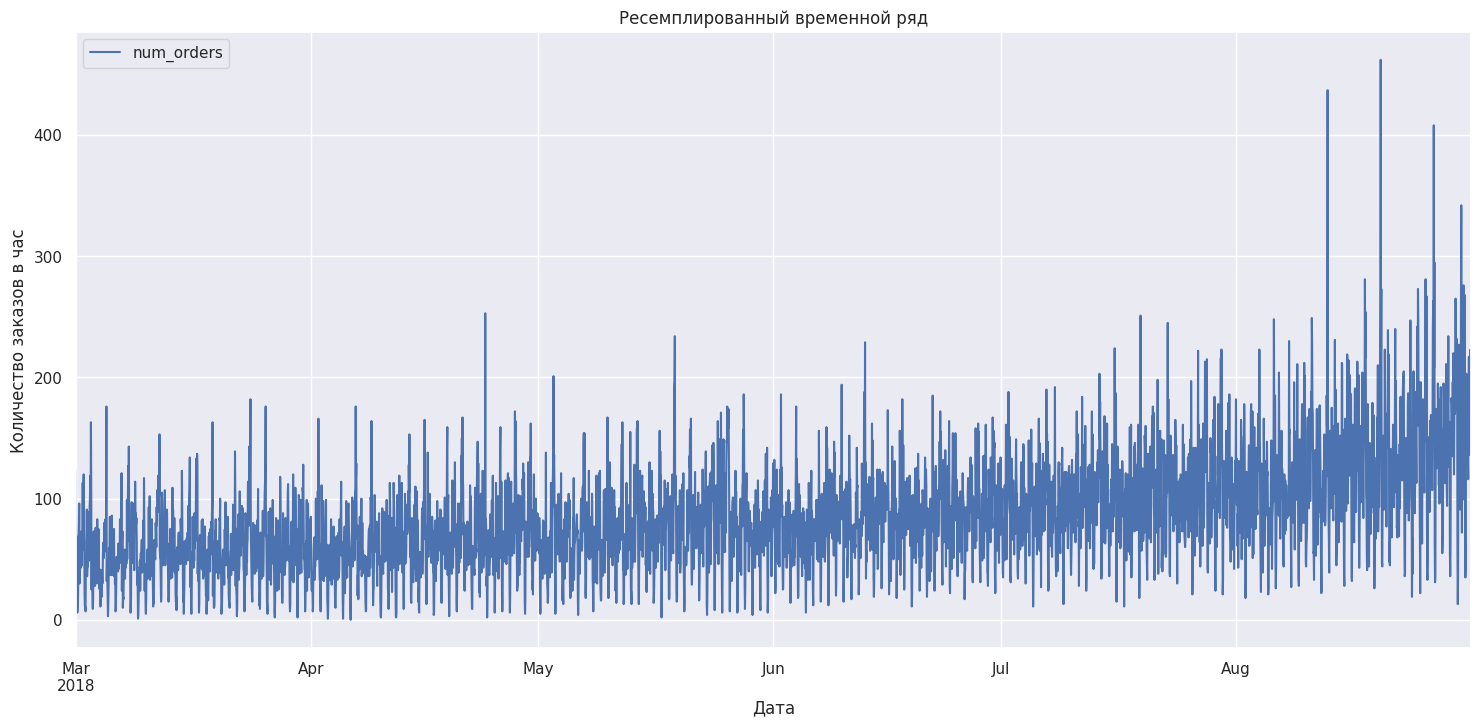

In [6]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Ресемплированный временной ряд');

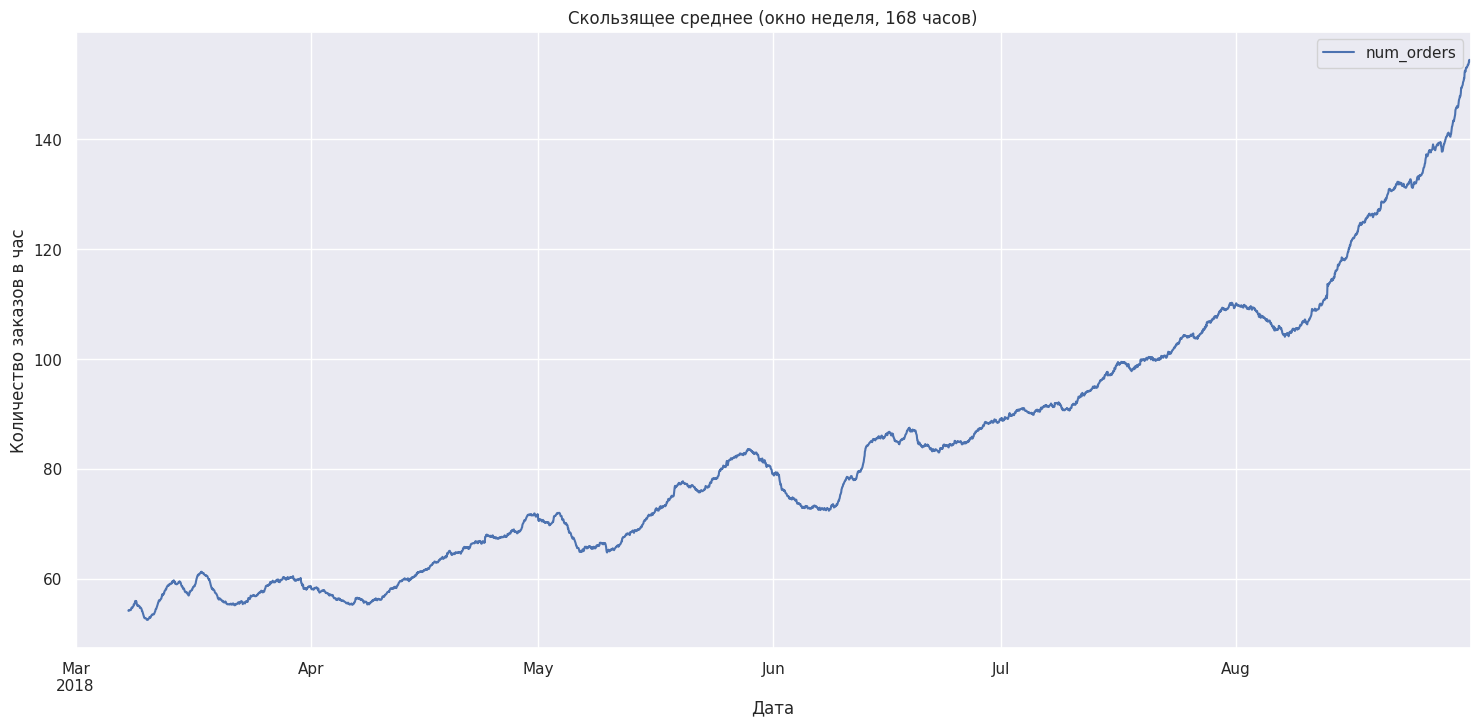

In [7]:
#Посмотрим скользящее среднее, чтобы оценить тренд
taxi.rolling(168).mean().plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Скользящее среднее (окно неделя, 168 часов)');

Окно скользящего среднего приняла 168 часов (равное неделе) с целью убрать и суточную и недельную сезонность\
График за такой период нам мало что дает, хотя общий тренд к увеличению заказов мы здесь видим.\
Посмотрим более короткий период. Возьмем последнюю полную неделю августа, не касаясь кануна 1 сентября, там могут быть особенности, связанные с началом учебного года.

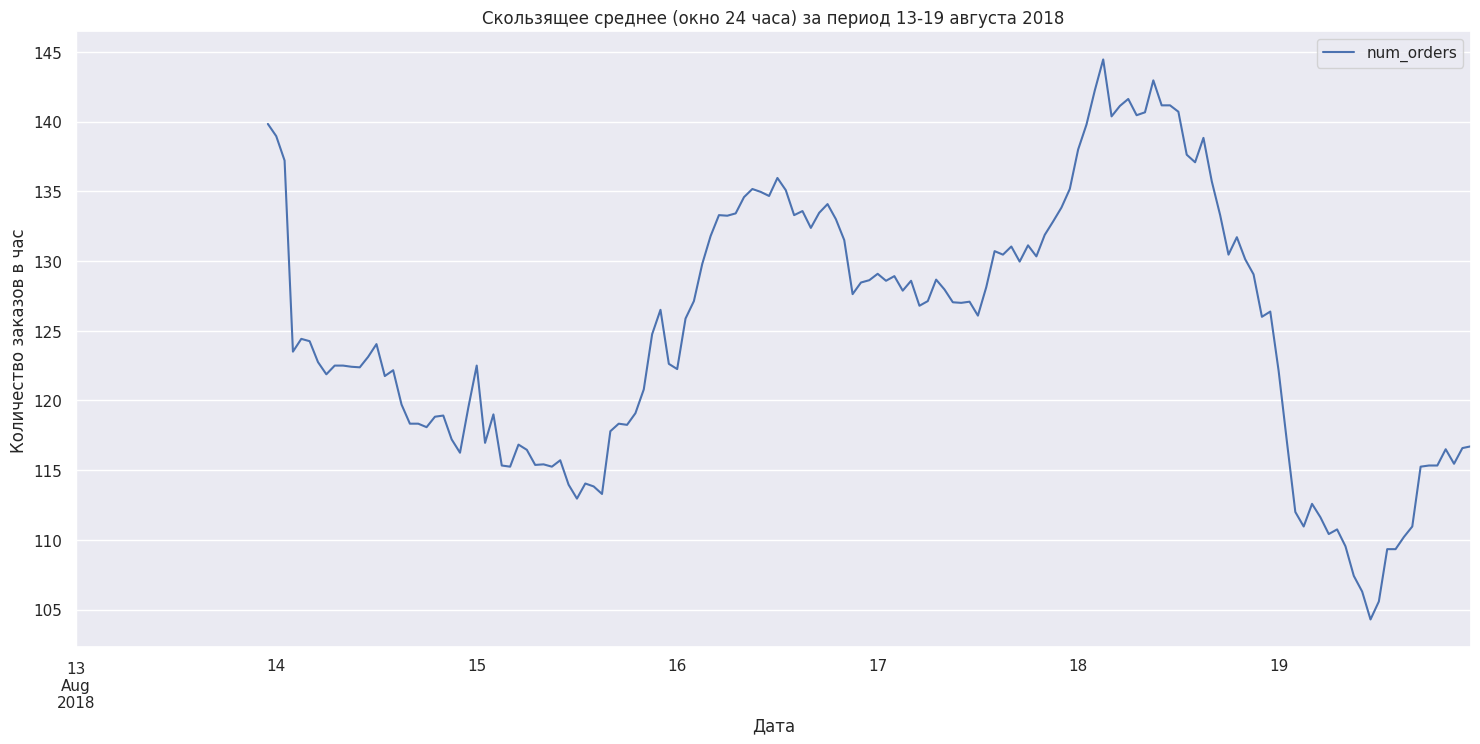

In [8]:
taxi['2018-08-13':'2018-08-19'].rolling(24).mean().plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Скользящее среднее (окно 24 часа) за период 13-19 августа 2018');

Cкользящее окно приняла равное суткам, чтобы сразу убрать суточную сезонность и увидеть недельную.

**Благодаря скользящему среднему с окном равным суткам, мы видим тренды к увеличению заказов такси в понедельник, снижению во вторник и среду с ростом в четверг, пятницу и субботу, и резким падением заказов в воскресенье**

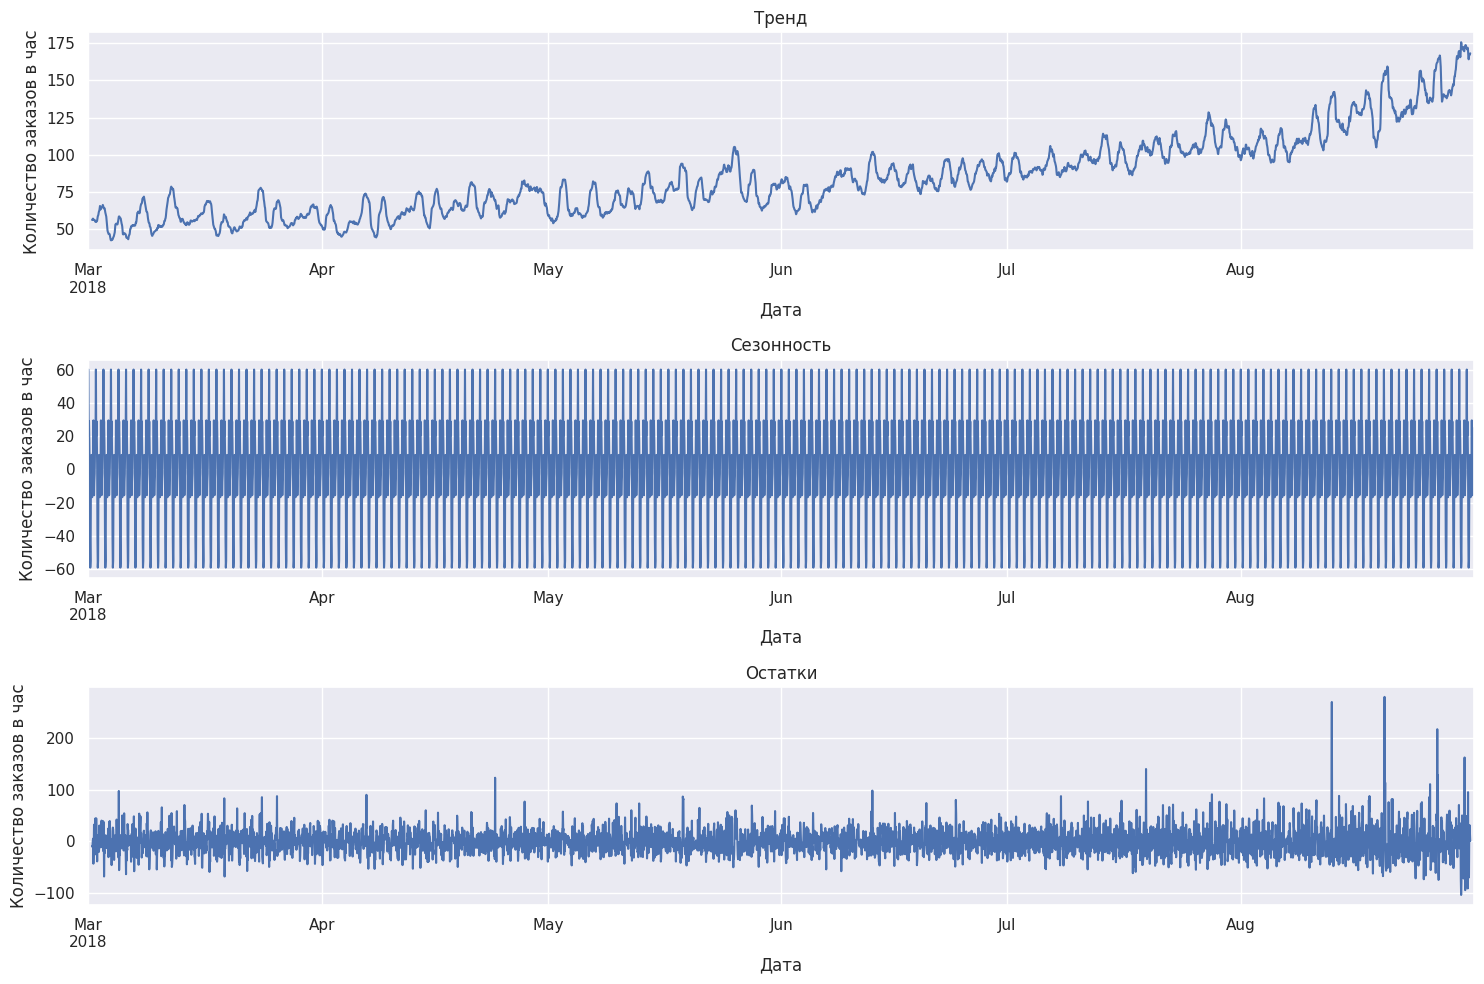

In [9]:
# Рассмотрим тренды, сезонность, остаток декомпозиции заказа такси
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Остатки')
plt.tight_layout();

**Графики показывают высокую частотность, восходящий тренд, суточную сезонность\
Посмотрим срез сезонности за нашу неделю в августе с 13го по 19е**

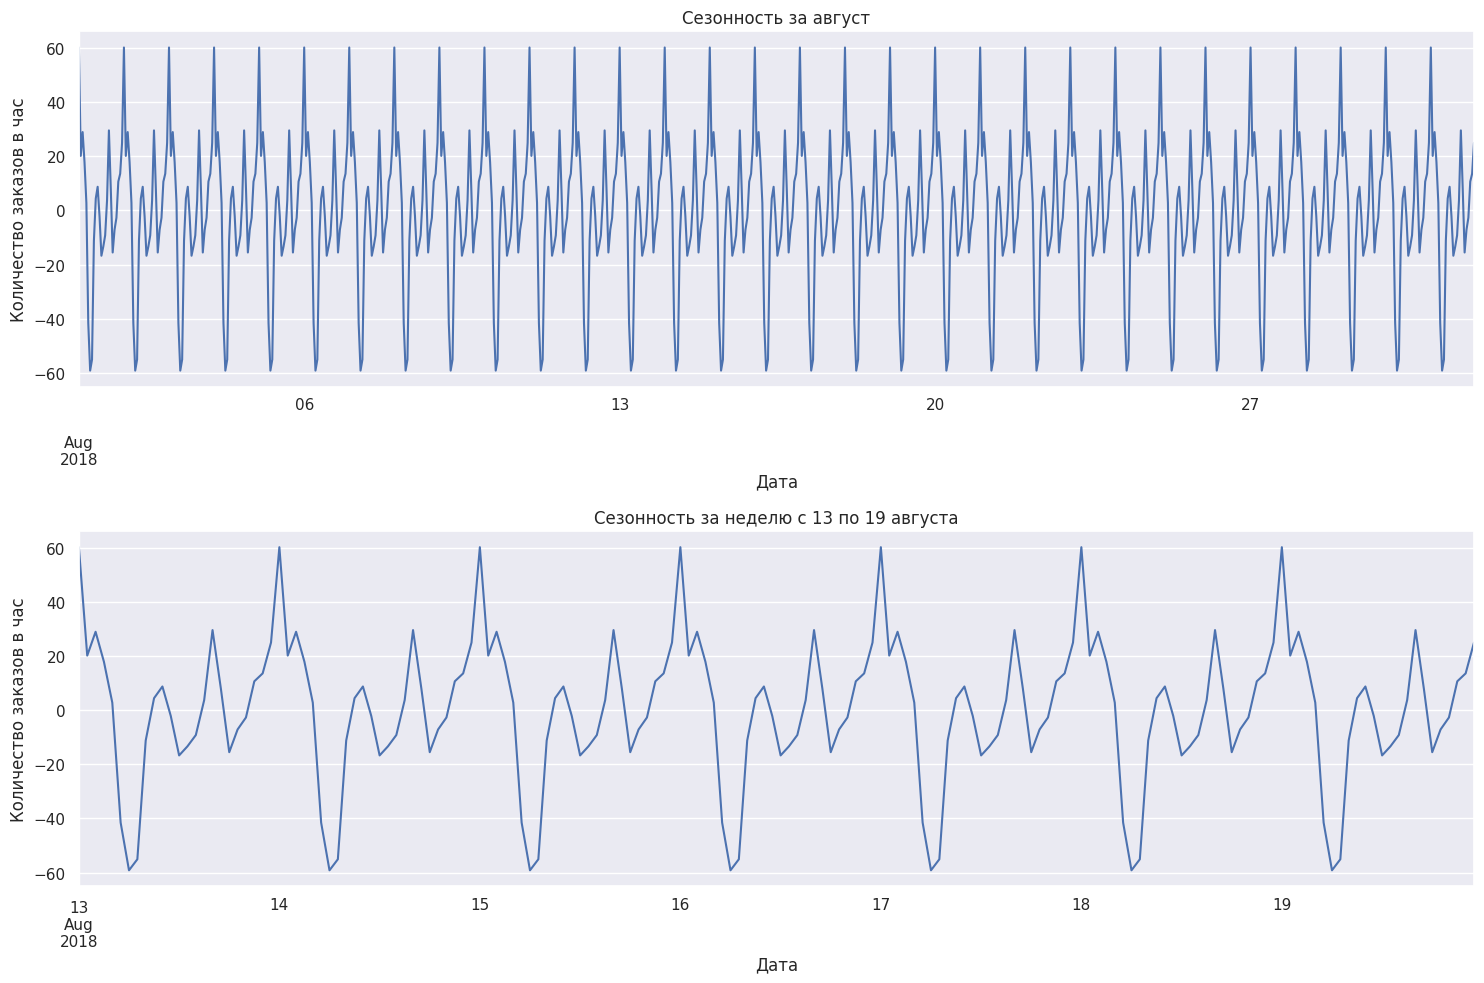

In [10]:
# Рассмотрим тренды, сезонность, остаток декомпозиции заказа такси на период
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(15, 10))

plt.subplot(211)
decomposed.seasonal['2018-08-01': '2018-08-31'].plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Сезонность за август')

plt.subplot(212)
decomposed.seasonal['2018-08-13': '2018-08-19'].plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Сезонность за неделю с 13 по 19 августа')

plt.tight_layout();

**Здесь хорошо видно наличие суточного тренда. Максимум заказов происходит около нуля часов, затем идет спад почти в ноль заказов к утру, и далее тренд на подьем к новому максимуму с двумя пиками до него - утром в начале рабочего дня и вечером, в конце рабочего дня**

Хорошо было бы посмотреть недельную и месячную сезонность. Но, увы, для месячной сезоннности слишком мало данных (меньше года).\
Посмотрим недельную сезонность.\
Для этого ресемплируем ряд по суткам:

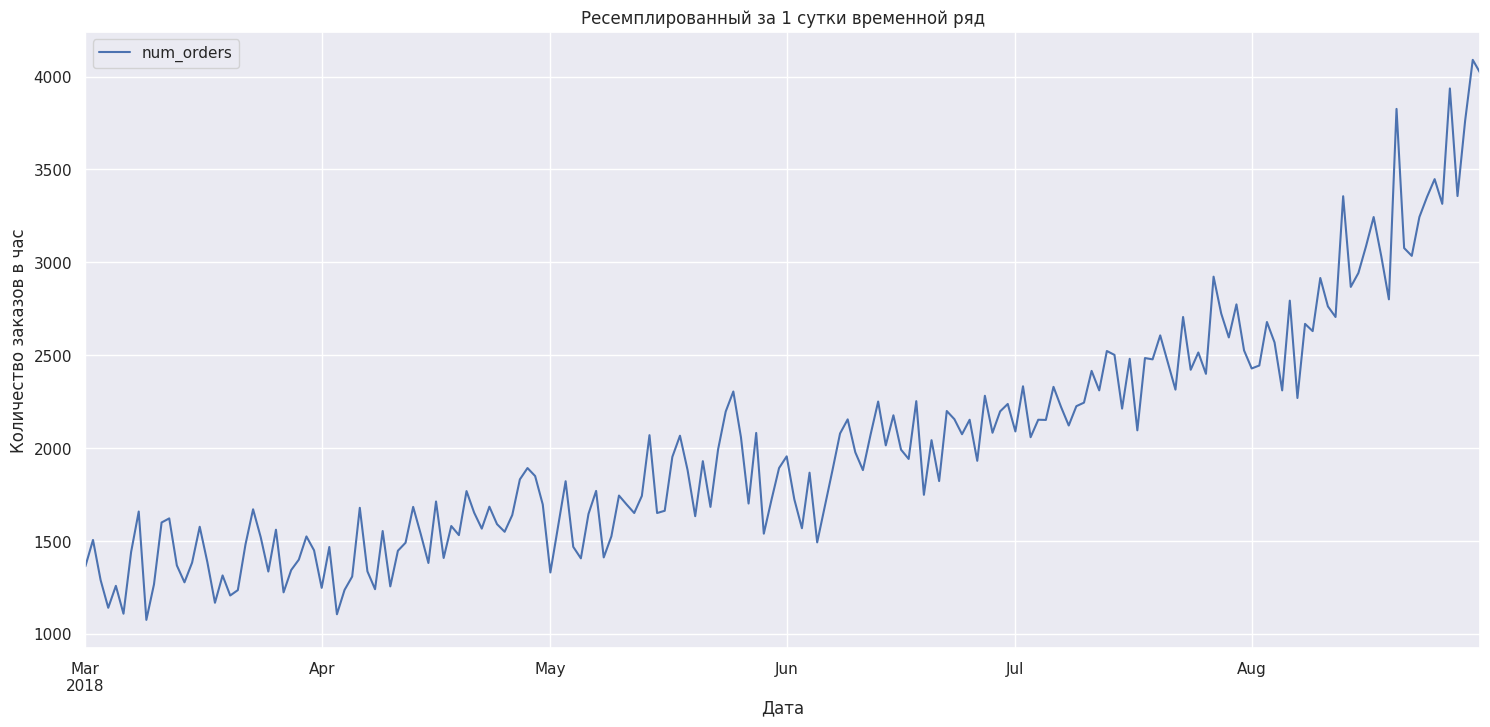

In [11]:
#ресемплируем в новую переменную, поскольку для моделей нам нужен ресемплированный по суткам ряд
taxi_day = taxi.resample('1D').sum()
taxi_day.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Ресемплированный за 1 сутки временной ряд');

И теперь посмотрим на недельную сезонность:

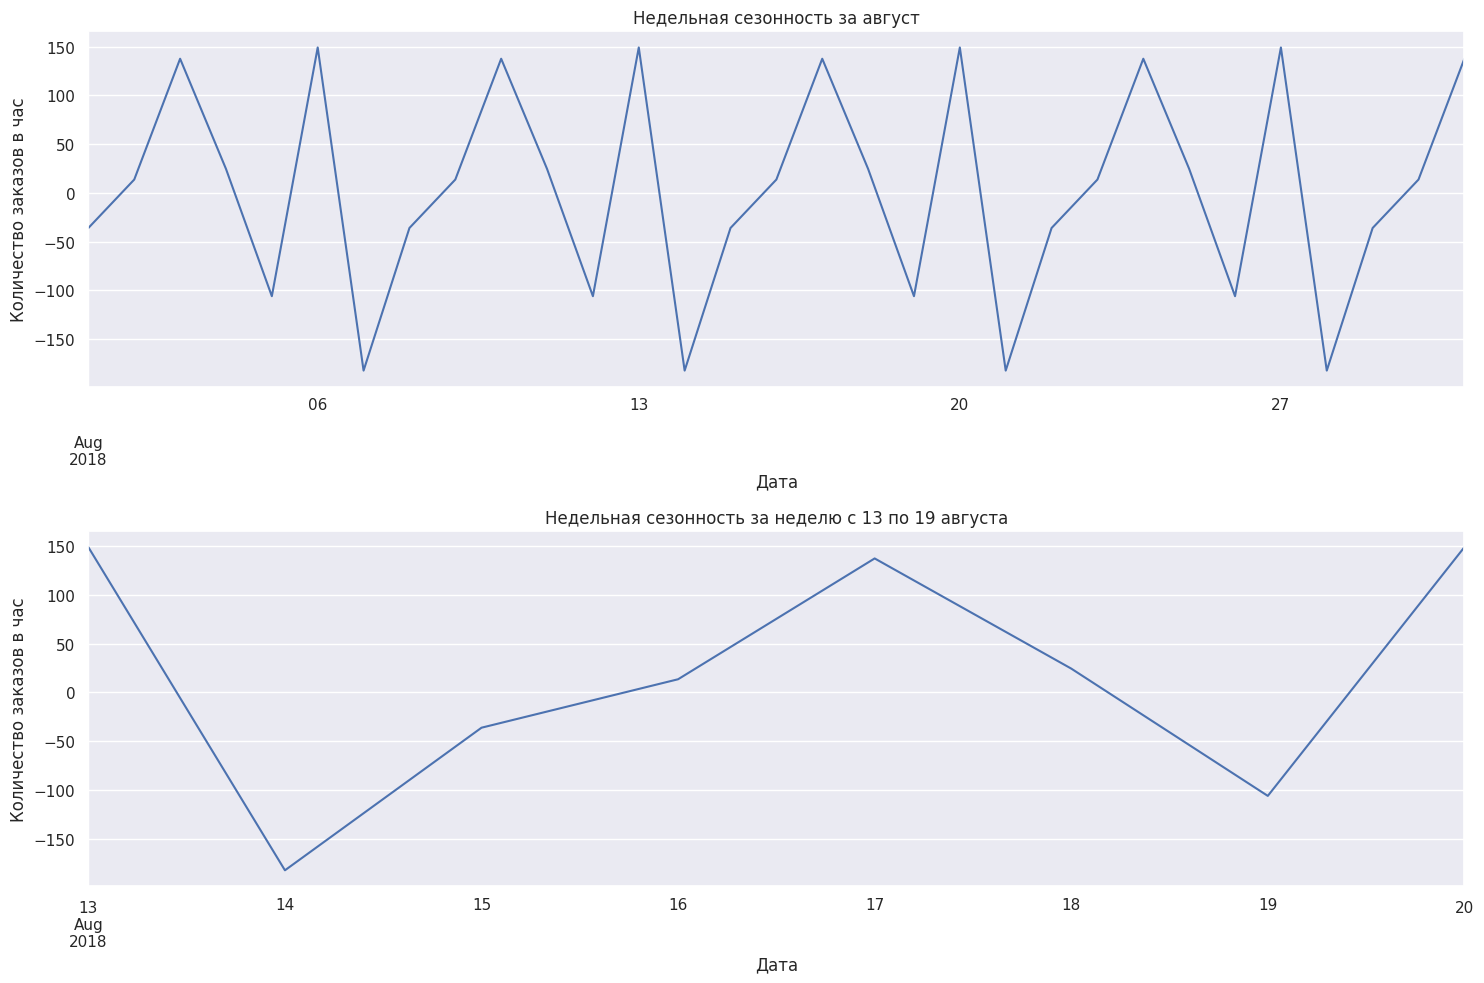

In [12]:
decomposed = seasonal_decompose(taxi_day)

plt.figure(figsize=(15, 10))

plt.subplot(211)
decomposed.seasonal['2018-08-01 00:00:00': '2018-08-31 00:00:00'].plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Недельная сезонность за август')

plt.subplot(212)
decomposed.seasonal['2018-08-13 00:00:00': '2018-08-20 00:00:00'].plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Недельная сезонность за неделю с 13 по 19 августа')

plt.tight_layout();

**Здесь уже хорошо виден недельный тренд с двумя максимумами, в ночь с воскресенья на понедельник и в 00 часов по пятницам. При этом недельный тренд имеет минимум во вторник в 00 часов, и второй минимум - в 00 часов в воскресенье**

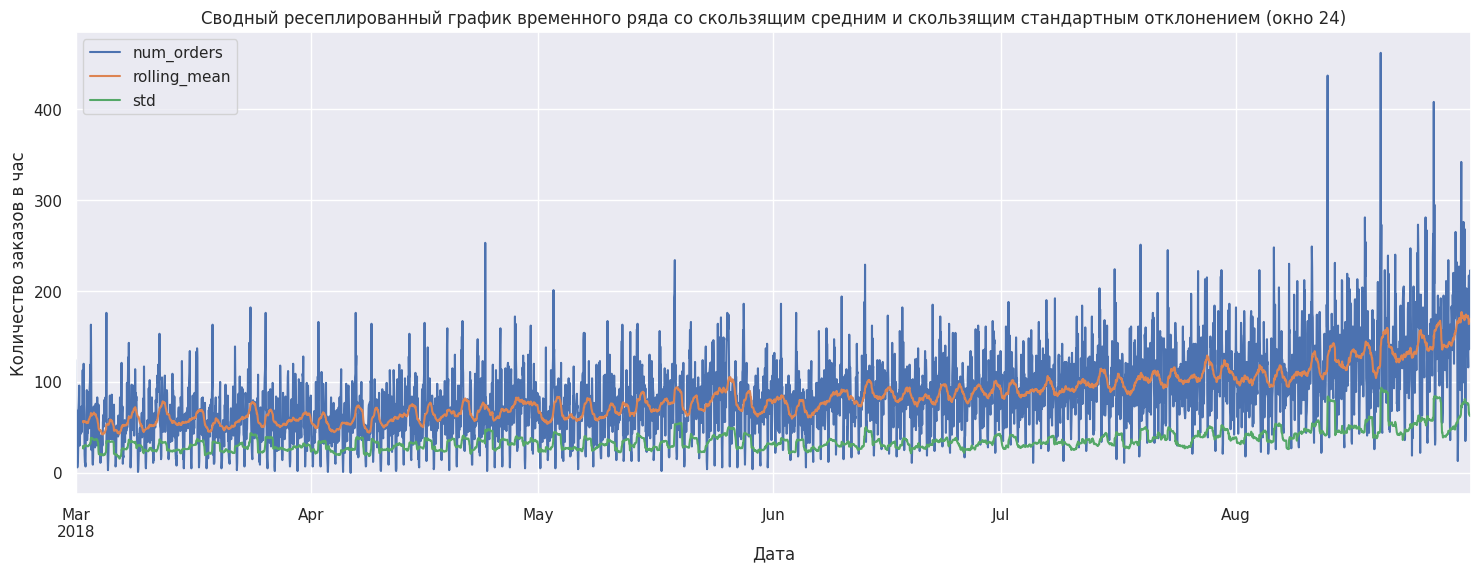

In [13]:
taxi_plot=taxi.copy()
taxi_plot['rolling_mean'] = taxi_plot.rolling(24).mean()
taxi_plot['std'] = taxi_plot['num_orders'].rolling(24).std()
taxi_plot.plot(figsize=(18, 6))
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час')
plt.title('Сводный ресеплированный график временного ряда со скользящим средним и скользящим стандартным отклонением (окно 24)');


### Промежуточный вывод

- Графики показывают высокую частотность, восходящий тренд, суточную и недельную сезонности
- Суточная сезонность:
    - Максимум заказов происходит около нуля часов, затем идет спад почти в ноль заказов к утру, и далее тренд на подьем к новому максимуму с двумя пиками до него - утром в начале рабочего дня и вечером, в конце рабочего дня
- Недельная сезонность:
    - Имеется недельный тренд с двумя максимумами, в ночь с воскресенья на понедельник и в 00 часов по пятницам. При этом недельный тренд имеет минимум во вторник в 00 часов, и второй минимум - в 00 часов в воскресенье
    - На графиках видна суточная сезонность, значит нужно будет учесть час, в который сделан заказ.
- Поскольку мы видим суточную и недельную сехзонность, в модели необходимо будет учесть час и день недели.

### Проверка ряда на стационарность.

Выполним расширенный тест Дики-Фуллера на стационарность ряда:

In [14]:
adfuller(taxi)

(-3.0689242890279504,
 0.028940051402613316,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

In [15]:
test = adfuller(taxi)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
#if test[0]> test[4]['5%']:
    #print('есть единичные корни, ряд не стационарен')
#else:
    #print('единичных корней нет, ряд стационарен')

adf:  -3.0689242890279504
p-value:  0.028940051402613316
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


#### Вывод о стационарности ряда:

- По тесту Дики-Фуллера значения "пограничные", при уровне значимости 5% мы можем говорить о стационарности, а при уровне значимости 1% уже нет. Похоже, что мы имеем дело с ложным срабатыванием теста.
- Нестационарный временной ряд может иметь тренд (постоянный рост или падение) или сезонность. В рассматриваемом ряду имеется и восходящий тренд, и суточная и недельная сезонность, а это говорит о том, что ряд нестационарен.
- Поскольку для построения признаков и обучения модели машинного обучения стационарность не является обязательной, приводить ряд к стационарному не требуется.


Если бы нам была критична нестационарность ряда (например, при использовании ARIMA), можно было бы воспользоваться разностями временного ряда, чтобы привести ряд к стационарному, например, так:

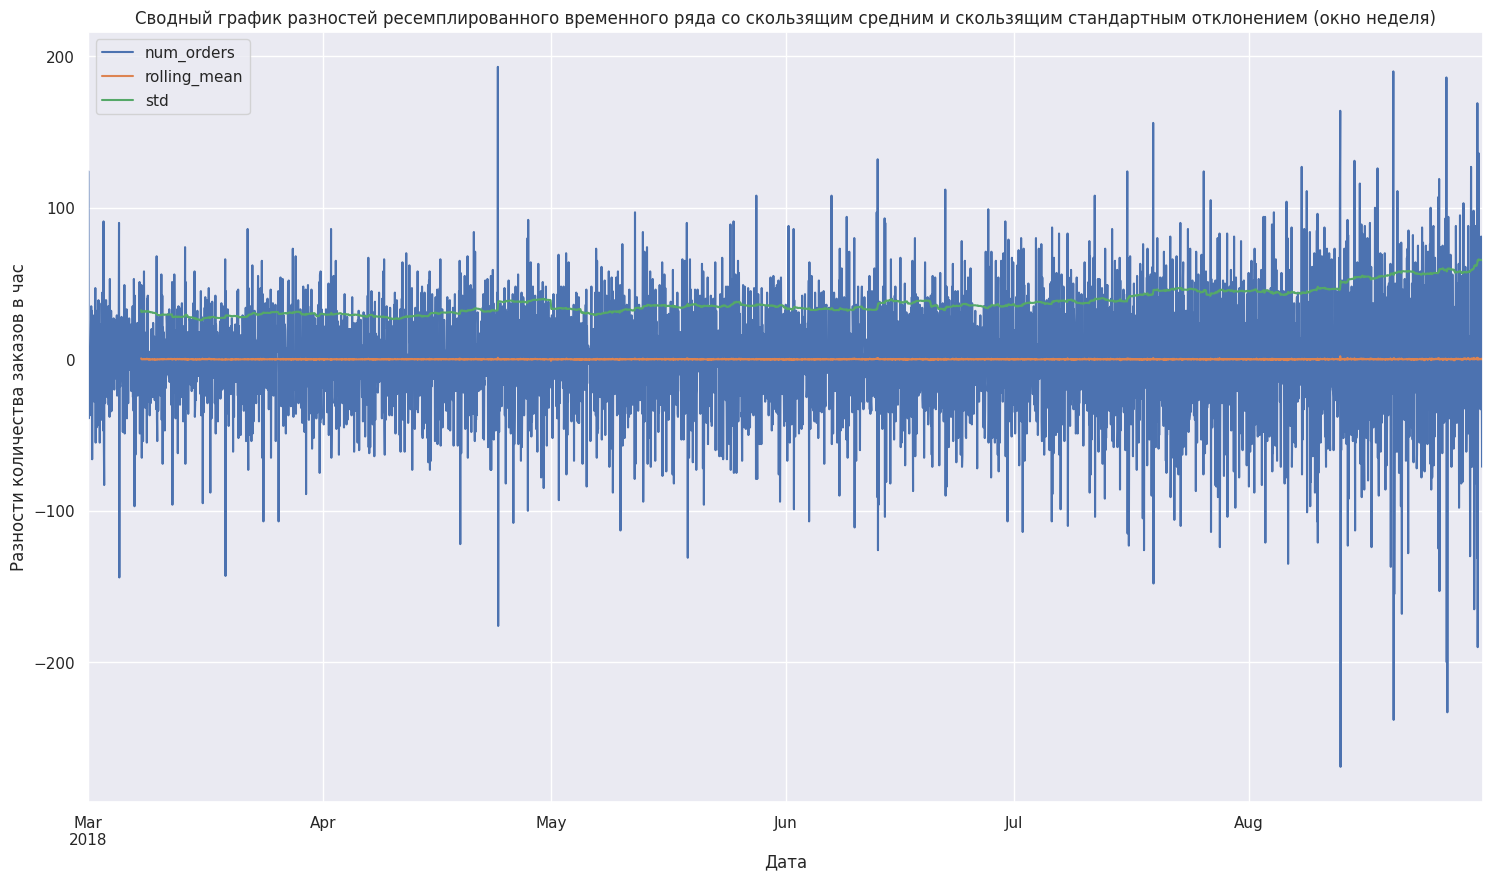

In [16]:
taxi_shift=taxi.copy()
taxi_shift = taxi_shift - taxi_shift.shift(fill_value=0)
taxi_shift['rolling_mean'] = taxi_shift.rolling(168).mean()
taxi_shift['std'] = taxi_shift['num_orders'].rolling(168).std()
taxi_shift.plot(figsize=(18, 10))
plt.xlabel('Дата')
plt.ylabel('Разности количества заказов в час')
plt.title('Сводный график разностей ресемплированного временного ряда со скользящим средним и скользящим стандартным отклонением (окно неделя)');

## Обучение моделей

Создадим необходимые признаки (день недели, час)

In [17]:
# Функция для создания признаков:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    #data = data.dropna()

In [18]:
make_features(taxi, 168, 168)
taxi.isna().sum()

,0
num_orders,0
dayofweek,0
hour,0
lag_1,1
lag_2,2
...,...
lag_165,165
lag_166,166
lag_167,167
lag_168,168


In [19]:
#Удалим пропуски:
taxi.dropna(inplace=True)
taxi.isna().sum().sum()

0

In [20]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


Поделилось корректно, тестовая выборка по времени позже, чем обучающая

In [21]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']
print(X_train.shape, y_train.shape, '\n\n', X_test.shape, y_test.shape)

(3823, 171) (3823,) 

 (425, 171) (425,)


In [22]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [23]:
# Создадим результирующую таблицу:
result_table = pd.DataFrame(columns=['model', 'RMSE'])

### Линейная модель (LinearRegression)

In [24]:
# Создаем список числовых колонок
num_columns = X_train.select_dtypes(include='number').columns.tolist()

# Пишем препроцессор под масштабирование:
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# Масштабируем
X_train_st = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

In [25]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

In [26]:
%%time

#Обьявим и обучим модель
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,)
regression.fit(X_train_st, y_train)

#Определим RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(
    regression,
    X_train_st,
    y_train,
    scoring=RMSE_score,
    cv=my_cv)).mean()*(-1)
print('RMSE', regression_cv_score)


RMSE 24.560409356708107
CPU times: user 2.27 s, sys: 87.8 ms, total: 2.36 s
Wall time: 3.74 s


In [27]:
result_table_1 = pd.DataFrame(
            {
                'model': 'LinearRegression', 'RMSE': round(regression_cv_score, 2),
                }, index=[0])
result_table = pd.concat([result_table, result_table_1], ignore_index = True)
result_table

,model,RMSE
0,LinearRegression,24.56


### Модель Дерево решений (DecisionTreeRegressor)

In [28]:
RANDOM_STATE=42

In [29]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)
#Объявляю модель
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
#Определяю словарь с набором параметров
tree_parametrs = {
                     'max_features': range(5, 20, 3),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
tree_rs = RandomizedSearchCV(tree, tree_parametrs, scoring=RMSE_score, cv=my_cv)
tree_rs.fit(X_train, y_train)
tree_rs.best_params_
print('Лучшая модель и её параметры:\n\n', tree_rs.best_params_)
-tree_rs.best_score_

Лучшая модель и её параметры:

 {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 8, 'max_depth': 7}
CPU times: user 1.64 s, sys: 13.9 ms, total: 1.65 s
Wall time: 2.32 s


30.467939420277713

In [30]:
result_table_2 = pd.DataFrame(
            {
                'model': 'DecisionTreeRegressor', 'RMSE': round(-tree_rs.best_score_, 2),
                }, index=[1])
result_table = pd.concat([result_table, result_table_2], ignore_index = True)
result_table

,model,RMSE
0,LinearRegression,24.56
1,DecisionTreeRegressor,30.47


### Ансамбль моделей дерево решений (RandomForestRegressor)

In [31]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(X_train)
#Объявляю модель
forest = RandomForestRegressor(random_state=RANDOM_STATE)
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_rs = RandomizedSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_rs.fit(X_train, y_train)
forest_rs.best_params_
print('Лучшая модель и её параметры:\n\n', forest_rs.best_params_)
-forest_rs.best_score_

Лучшая модель и её параметры:

 {'n_estimators': 20, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 13}
CPU times: user 55.1 s, sys: 88.3 ms, total: 55.1 s
Wall time: 59.9 s


24.211339170478855

In [32]:
result_table_3 = pd.DataFrame(
            {
                'model': 'RandomForestRegressor', 'RMSE': round(-forest_rs.best_score_, 2),
                }, index=[2])
result_table = pd.concat([result_table, result_table_3], ignore_index = True)
result_table

,model,RMSE
0,LinearRegression,24.56
1,DecisionTreeRegressor,30.47
2,RandomForestRegressor,24.21


### Градиентный бустинг (CatBoost)

In [33]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(X_train)
#Объявляю модель
cat = CatBoostRegressor(random_state=RANDOM_STATE)
#Определяю словарь с набором параметров
cat_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
cat_grid = GridSearchCV(cat, cat_parametrs, scoring=RMSE_score, cv=my_cv)
cat_grid.fit(X_train, y_train, verbose=100)

cat_grid.best_params_
print('Лучшая модель и её параметры:\n\n', cat_grid.best_params_)
-cat_grid.best_score_

0:	learn: 29.2166287	total: 59.2ms	remaining: 59.1s
100:	learn: 16.3388880	total: 1.02s	remaining: 9.08s
200:	learn: 14.4618998	total: 1.94s	remaining: 7.7s
300:	learn: 13.2267810	total: 2.84s	remaining: 6.61s
400:	learn: 11.9269045	total: 3.76s	remaining: 5.61s
500:	learn: 10.8067853	total: 5.25s	remaining: 5.23s
600:	learn: 9.9265114	total: 7.09s	remaining: 4.71s
700:	learn: 9.1008814	total: 8.5s	remaining: 3.63s
800:	learn: 8.3999250	total: 9.38s	remaining: 2.33s
900:	learn: 7.6952116	total: 10.3s	remaining: 1.13s
999:	learn: 7.0689105	total: 11.2s	remaining: 0us
0:	learn: 32.5684409	total: 15.4ms	remaining: 15.4s
100:	learn: 18.2123696	total: 1.15s	remaining: 10.2s
200:	learn: 16.6655513	total: 2.28s	remaining: 9.05s
300:	learn: 15.6356843	total: 3.38s	remaining: 7.86s
400:	learn: 14.7235021	total: 4.5s	remaining: 6.73s
500:	learn: 13.9159471	total: 5.6s	remaining: 5.58s
600:	learn: 13.2179096	total: 6.78s	remaining: 4.5s
700:	learn: 12.5817002	total: 9.03s	remaining: 3.85s
800:	le

23.602841987726535

In [34]:
result_table_4 = pd.DataFrame(
            {
                'model': 'CatBoost', 'RMSE': round(-cat_grid.best_score_, 2),
                }, index=[3])
result_table = pd.concat([result_table, result_table_4], ignore_index = True)
result_table

,model,RMSE
0,LinearRegression,24.56
1,DecisionTreeRegressor,30.47
2,RandomForestRegressor,24.21
3,CatBoost,23.60


### LGBMRegressor

In [35]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(X_train)
#Объявляю модель
lgbm = LGBMRegressor(random_state=RANDOM_STATE)
#Определяю словарь с набором параметров
lgbm_parametrs = {'num_leaves':[25, 50, 100, 200],
                  'learning_rate':[.1, .3, .5],
                  'random_state':[12345]}

#Применяю GridSearchCV с кросс-валидацией
lgbm_grid = GridSearchCV(lgbm, lgbm_parametrs, scoring=RMSE_score, cv=my_cv)
lgbm_grid.fit(X_train, y_train)

lgbm_grid.best_params_
print('Лучшая модель и её параметры:\n\n', lgbm_grid.best_params_)
-lgbm_grid.best_score_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19524
[LightGBM] [Info] Number of data points in the train set: 958, number of used features: 171
[LightGBM] [Info] Start training from score 58.658664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24283
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 171
[LightGBM] [Info] Start training from score 65.325144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27778
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 171
[LightGBM] [Info] Start

24.018528835224743

In [36]:
result_table_5 = pd.DataFrame(
            {
                'model': 'LGBMRegressor', 'RMSE': round(-lgbm_grid.best_score_, 2),
                }, index=[4])
result_table = pd.concat([result_table, result_table_5], ignore_index = True)
result_table

,model,RMSE
0,LinearRegression,24.56
1,DecisionTreeRegressor,30.47
2,RandomForestRegressor,24.21
3,CatBoost,23.60
4,LGBMRegressor,24.02


### Промежуточный вывод.
Обучены 5 моделей:
- LinearRegression (простая линейная модель)
- DecisionTreeRegressor
- RandomForestRegression
- CatBoost
- LGBMRegressor

Для всех моделей, кроме первой (она простая) подобраны гиперпараметры.
Всем моделям удалось достичь требуемого показателя метрики RMSE - не более 48,0, рассчитанной на кросс-валидации:

|index|model|RMSE|
|---|---|---|
|0|LinearRegression|24\.56|
|1|DecisionTreeRegressor|30\.47|
|2|RandomForestRegressor|24\.21|
|3|CatBoostRegressor:|23\.60|
|4|LGBMRegressor|24\.02|

## Анализ моделей

### Анализ результирующей таблицы

In [37]:
result_table

,model,RMSE
0,LinearRegression,24.56
1,DecisionTreeRegressor,30.47
2,RandomForestRegressor,24.21
3,CatBoost,23.60
4,LGBMRegressor,24.02


### Проверка на адекватность модели

In [38]:
# Проверка на адекватность модели
pred_previous = X_test.shift()
pred_previous.iloc[0] = X_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(X_test, pred_previous), 2))

RMSE для проверки модели на адекватность: 56.44


**Таким образом, модели с меньшим, чем 56.44, значением RMSE - будут адекватны**

In [39]:
model_dc = DummyRegressor(strategy="median")
model_dc.fit(X_train, y_train)
result_dc = mean_squared_error(y_test,model_dc.predict(X_test))**0.5

print('RMSE DummyRegressor:', round(result_dc, 2))

RMSE DummyRegressor: 87.04


**Таким образом, (возьмем меньшее значение из двух наших тестов) модели, имеющие значением RMSE меньшее, чем 56.44,  - будут адекватны**

### Проверка выбранной модели CatBoostRegressor на тестовой выборке.

Напишем функцию для визуализации на графике предсказаний моделей и реальных данных тестовой выборки

In [40]:
def visualization(predictions):
    model_data = pd.DataFrame({"target":y_test, "predict":predictions})
    model_data.plot(figsize=(15, 7))
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов в час')
    plt.title('Совмещенный график целевых знаечний и предсказаний модели')
    # возьмем 3хдневный интервал, дни можно взять любые, но пусть будут эти
    model_data['2018-08-15':'2018-08-17'].plot(figsize=(20, 10))
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов в час')
    plt.title('Совмещенный график целевых знаечний и предсказаний модели за интервал 13-19 августа 2018')


In [41]:
%%time

#Обучим модель на оптимальных гиперпараметрах
cat_model = cat_grid.best_estimator_
cat_model.fit(X_train, y_train)
cat_model_predictions = cat_model.predict(X_test)
# Масштабируем тестовую выборку
#X_test = pd.DataFrame(
    #data_preprocessor.fit_transform(X_test),
    #columns=data_preprocessor.get_feature_names_out()
#)
#RMSE
cat_RMSE = round(RMSE(y_test, cat_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cat_RMSE)

0:	learn: 38.2392252	total: 14.5ms	remaining: 14.5s
1:	learn: 37.6210340	total: 29.7ms	remaining: 14.8s
2:	learn: 37.0263159	total: 54.4ms	remaining: 18.1s
3:	learn: 36.5057127	total: 69.2ms	remaining: 17.2s
4:	learn: 35.9669133	total: 88ms	remaining: 17.5s
5:	learn: 35.4567483	total: 108ms	remaining: 17.9s
6:	learn: 34.9544799	total: 123ms	remaining: 17.5s
7:	learn: 34.4793006	total: 138ms	remaining: 17.2s
8:	learn: 34.0081640	total: 156ms	remaining: 17.1s
9:	learn: 33.5570038	total: 170ms	remaining: 16.9s
10:	learn: 33.1056525	total: 185ms	remaining: 16.6s
11:	learn: 32.6576727	total: 200ms	remaining: 16.4s
12:	learn: 32.2161400	total: 218ms	remaining: 16.5s
13:	learn: 31.8361623	total: 235ms	remaining: 16.6s
14:	learn: 31.4523579	total: 249ms	remaining: 16.4s
15:	learn: 31.0767063	total: 267ms	remaining: 16.4s
16:	learn: 30.7172714	total: 284ms	remaining: 16.4s
17:	learn: 30.3906271	total: 302ms	remaining: 16.5s
18:	learn: 30.0668840	total: 320ms	remaining: 16.5s
19:	learn: 29.75070

Итак, RMSE модели CatBoostRegressor на тестовой выборке : 36.779. Модель адекватна.

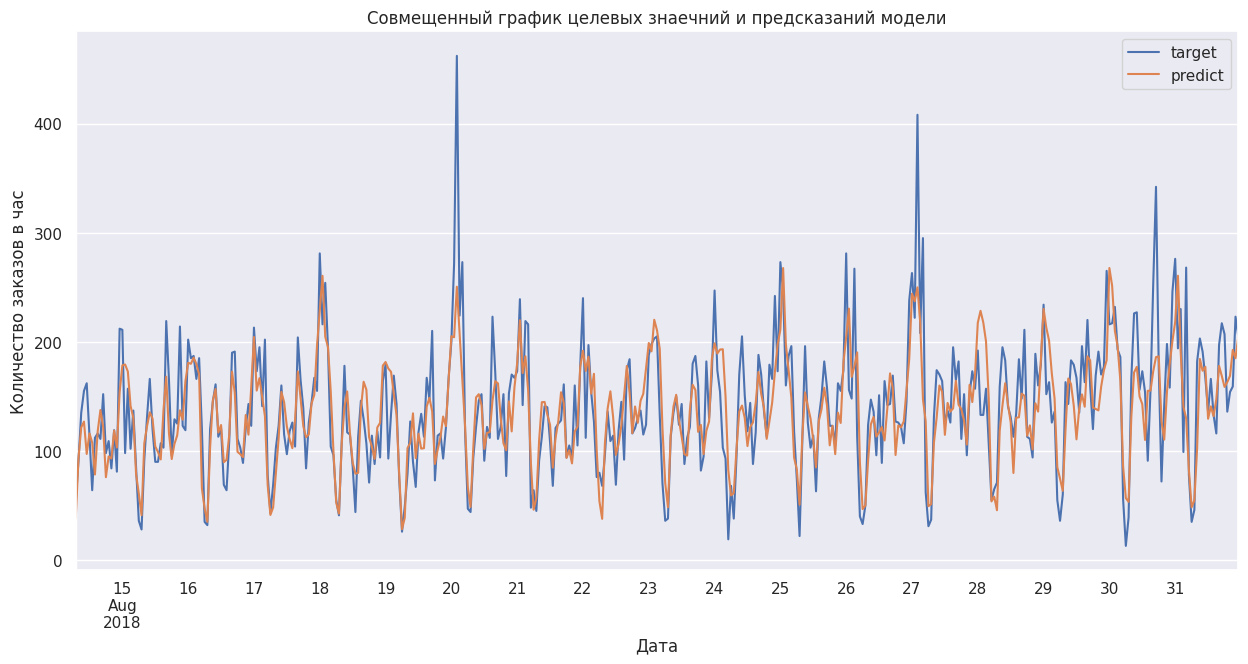

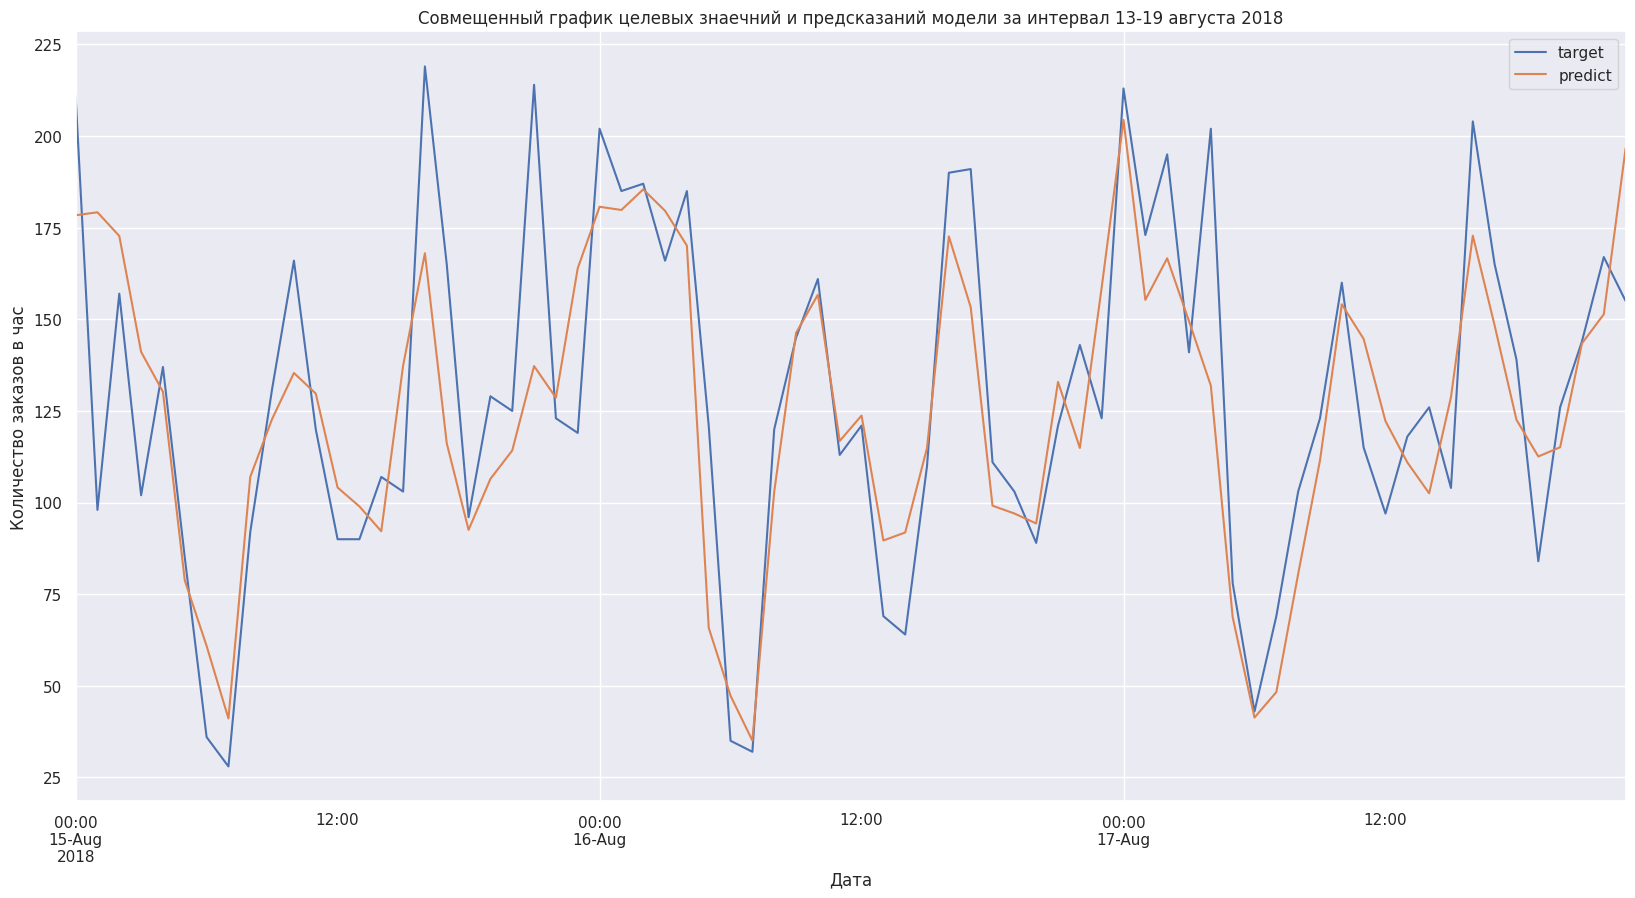

In [42]:
visualization(cat_model_predictions)

Модель CatBoost предсказывает неплохо. Не пропущено практически ни одного пика. Её метрика лучше, чем у предыдущих моделей, поэтому именно ее и рекомендуем заказчику.

## Общий вывод
При выполнении проекта проделана следующая работа:

- Произведена загрузка данных, их ресемплирование по 1 часу, и их подготовка для обучения моделей.
- Графики показывают высокую частотность, восходящий тренд, суточную и недельную сезонности
- Суточная сезонность:
    - Максимум заказов происходит около нуля часов, затем идет спад почти в ноль заказов к утру, и далее тренд на подьем к новому максимуму с двумя пиками до него - утром в начале рабочего дня и вечером, в конце рабочего дня
- Недельная сезонность:
    - Имеется недельный тренд с двумя максимумами, в ночь с воскресенья на понедельник и в 00 часов по пятницам. При этом недельный тренд имеет минимум во вторник в 00 часов, и второй минимум - в 00 часов в воскресенье
    - На графиках видна суточная сезонность, значит нужно будет учесть час, в который сделан заказ.
- Поскольку мы увидели суточную и недельную сезонность, в модели учли час и день недели.

- Во время первичного исследования обнаружен определенный **тренд на общее увеличение количества заказов такси в час**. Это может быть связано с ростом компании, поскольку такси, скорее всего, не имеет месячной сезонности: нет предпосылок. Однако, это осталось гипотезой, которую можно было бы подтвердить или опровергнуть, только имея данные за несколько лет.
- На графиках явно видна **суточная сезонность**. Ночью количество заказов сильно уменьшается, при этом вечером наблюдается три последовательных пика, вероятно, связанные с окончанием рабочего дня и выездом по делам.
- На этапе обучения моделей, при подготовке данных к датасету были добавлены дополнительные признаки: день недели, час, "отстающие значения" (24 значения) и скользящее среднее (окно 24 часа). На дополнном датасете обучены модели (Линейная регрессия, Дерево решений, Случайный лес, и две модели градиентного бустинга -  CatBoost LGBMRegressor) и подобраны оптимальные гиперпараметры для них.
- Затем на кросс-валидации рассчитаны метрики RMSE для всех моделей. Всем моделям удалось достичь требуемого показателя метрики RMSE - не более 48,0, рассчитанной на кросс-валидации:

|index|model|RMSE|
|---|---|---|
|0|LinearRegression|24\.56|
|1|DecisionTreeRegressor|30\.47|
|2|RandomForestRegressor|24\.21|
|3|CatBoostRegressor:|23\.60|
|4|LGBMRegressor|24\.02|

Наилучший показатель RMSE в данном случае у CatBoostRegressor = 23.60.

- Проверка модели на адекватность показала, что все модели с метриками меньше, чем 56.44, могут считаться адекватными.
- RMSE модели CatBoostRegressor на тестовой выборке : 36.779. **Модель адекватна. Модель удовлетворяет условию: "Значение метрики RMSE на тестовой выборке должно быть не больше 48."**
- Анализ сравнительных графиков в двух масштабах, показал, что модель предсказывает хорошо, не пропуская практически ни одного пика. Модель хуже всего справляется с предсказаниями на высоких пиках и на части провалов, но в целом, угадывают направления движения.

Рекомендуем к использованию модель CatBoost с гиперпараметрами: {'depth': 4, 'learning_rate': 0.03}

- Дополнительно можно отметить:
   - хорошо было бы иметь больше данных и разобраться с гипотезой о сезонности такси
   - можно попробовать добавить признак "праздничный день", поскольку в праздничные дни точно изменяется поведение клиентов
   - неплохо было бы также добавить в прогнозную модель крупные события в городе, которые могут повлиять на количество вызовов в час не просто в дни этих событий, а в часы этих событий (крупный концерт, форум, конференция, спортивные соревнования масштаба страны или мирового масштаба)